In [1]:
from scripts import setup_environment

setup_environment()

In [2]:
from scripts.dataset import BrainteaserDataset

dataset = BrainteaserDataset("data")

In [3]:
import string

from scripts.dataset import RiddleQuestion
from scripts.prompt_helpers import create_prompt_template


def args_generator(riddle_question: RiddleQuestion):
    template_args = {
        "question": riddle_question.question,
        "choices": "\n".join(
            [
                f"({string.ascii_uppercase[j]}) {choice}"
                for j, choice in enumerate(riddle_question.choice_list)
            ]
        ),
    }

    return template_args


chat_prompt_template = create_prompt_template("default")

In [4]:
from scripts.lmm import OllamaModelBuilder
from scripts.executor import Executor

base_url = "http://108.179.129.43:32301"
# Ensure that the temperature is set to 0.0f, otherwise the model could be unstable due to taking risks
# but this will also make the model less creative. As we are interested in the stability of the model, this is not a problem.
model_builder = OllamaModelBuilder(base_url, temperature=0.0)

executor = Executor(
    models=[
        # Llama3.1
        model_builder.build_model("llama3.1:8b"),
        # Llama3.2
        model_builder.build_model("llama3.2:1b"),
        model_builder.build_model("llama3.2:3b"),
        # Phi3.5
        model_builder.build_model("phi3.5:3.8b"),
        # Phi4
        model_builder.build_model("phi4:14b"),
        # Qwen2.5
        model_builder.build_model("qwen2.5:0.5b"),
        model_builder.build_model("qwen2.5:1.5b"),
        model_builder.build_model("qwen2.5:3b"),
        model_builder.build_model("qwen2.5:7b"),
        model_builder.build_model("qwen2.5:14b"),
        model_builder.build_model("qwen2.5:32b"),
        # Gemma2
        model_builder.build_model("gemma2:2b"),
        model_builder.build_model("gemma2:9b"),
        model_builder.build_model("gemma2:27b"),
        # Mistral Nemo
        model_builder.build_model("mistral-nemo:12b"),
    ]
)

2025-03-02 22:36:38,458 - INFO - Initialized executor with 15 models.


In [5]:
import numpy as np

from scripts.executor import Dataset

# Set fixed seed for reproducibility
np.random.seed(42)


def create_test_dataset(data: list[RiddleQuestion], name: str, percentage: float = 0.1):
    """Create a test dataset by randomly sampling a percentage of the original data."""
    indices = np.random.choice(
        len(data), size=int(len(data) * percentage), replace=False
    )
    return Dataset(name=name, riddles=[data[i] for i in indices])


# Create test datasets
sp_data = create_test_dataset(dataset.sp, "sp")
wp_data = create_test_dataset(dataset.wp, "wp")

# Prepare executor data
executor_data = [sp_data, wp_data]

In [6]:
total_results = {}

for run_index in range(5):
    chat_prompt_template = create_prompt_template("default")
    results = await executor.aexecute(
        executor_data,
        chat_prompt_template,
        args_generator,
        dump_to_pickle=True,
        create_checkpoints=True,
        resume_from_checkpoint=True,
        run_name="model_stability_test",
        file_name_suffix=f"run_{run_index}",
    )
    total_results[run_index] = results

2025-03-02 22:36:38,481 - INFO - Starting execution 'model-stability-test with suffix 'run_0'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-0):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-02 22:36:38,580 - INFO - Starting execution 'model-stability-test with suffix 'run_1'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-1):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-02 22:36:38,700 - INFO - Starting execution 'model-stability-test with suffix 'run_2'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-2):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-02 22:36:38,727 - INFO - Starting execution 'model-stability-test with suffix 'run_3'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-3):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-02 22:36:38,879 - INFO - Starting execution 'model-stability-test with suffix 'run_4'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-4):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-02 22:40:55,843 - INFO - Saving results to results/model-stability-test/model-stability-test_run-4_results.pkl
2025-03-02 22:40:56,342 - INFO - Execution 'model-stability-test with suffix 'run_4'' completed successfully.


## Eval results


In [10]:
import os
import glob
import pickle
from pathlib import Path

# Define the results directory path
results_dir = Path("results/model-stability-test")

# Get all result files
result_files = glob.glob(str(results_dir / "model-stability-test_run-*_results.pkl"))

# Load all results into a dictionary
# The first key is the suffix (technique name)
total_results = {}

for file_path in result_files:
    # Extract the suffix from the filename
    suffix = os.path.basename(file_path).split("_")[1]

    # Load the results from the pickle file
    with open(file_path, "rb") as f:
        wrapped_results = pickle.load(f)
        total_results[suffix] = wrapped_results.results

print(f"Loaded {len(total_results)} result sets from disk.")

Loaded 5 result sets from disk.


Model Stability Analysis


Model: llama3.1:8b
--------------------------------------------------------------------------------
  Dataset: sp
    Stability: 66.13% (41/62 riddles with consistent answers)
    Answer variations: {1: 41, 2: 18, 3: 1, 4: 2}
  Dataset: wp
    Stability: 63.27% (31/49 riddles with consistent answers)
    Answer variations: {1: 31, 2: 14, 3: 4}

Model: llama3.2:1b
--------------------------------------------------------------------------------
  Dataset: sp
    Stability: 93.55% (58/62 riddles with consistent answers)
    Answer variations: {1: 58, 2: 4}
  Dataset: wp
    Stability: 97.96% (48/49 riddles with consistent answers)
    Answer variations: {1: 48, 2: 1}

Model: llama3.2:3b
--------------------------------------------------------------------------------
  Dataset: sp
    Stability: 61.29% (38/62 riddles with consistent answers)
    Answer variations: {1: 38, 2: 15, 3: 4, 4: 3, 5: 2}
  Dataset: wp
    Stability: 63.27% (31/49 riddles with consistent 

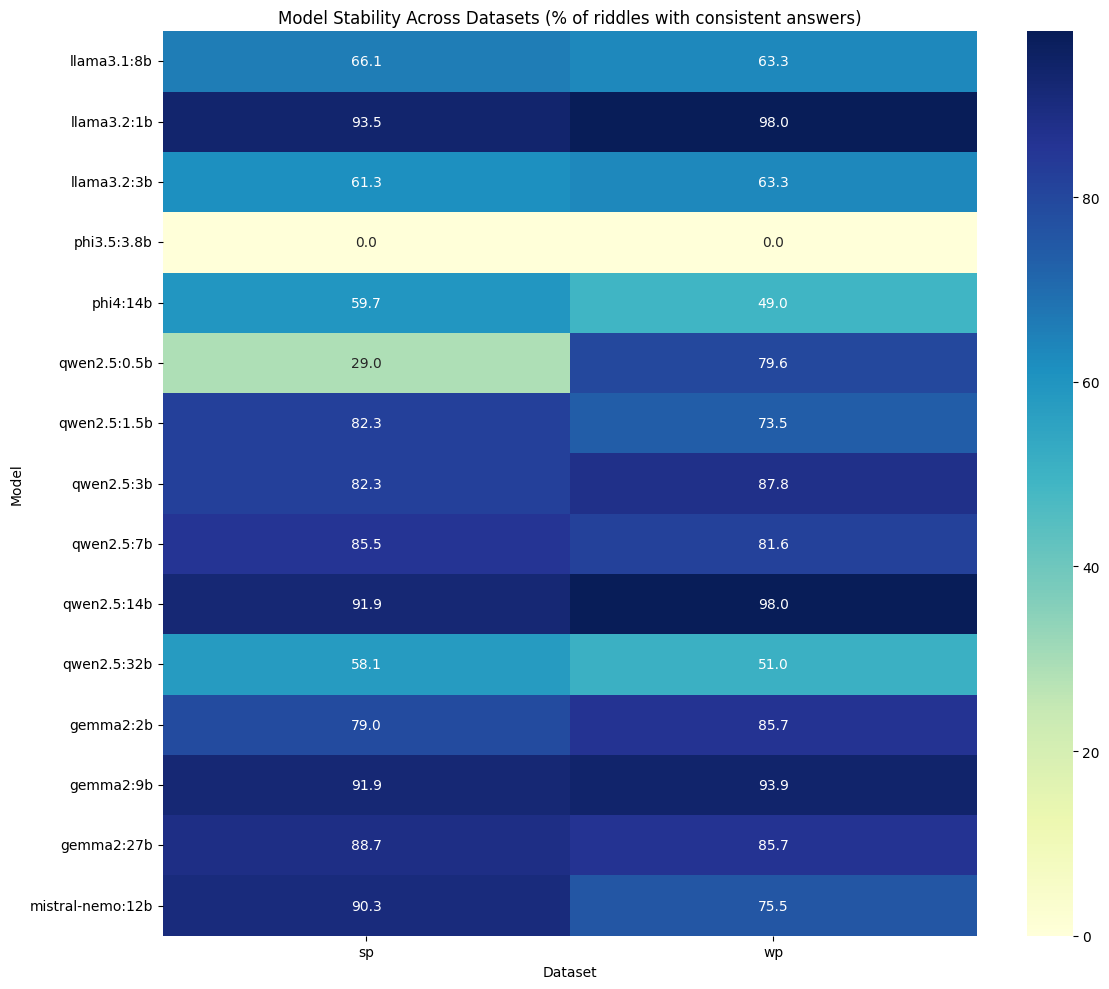

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def check_model_stability(total_results):
    model_stability = {}
    dataset_stability = {}

    run_names = list(total_results.keys())
    if not run_names:
        return {"error": "No runs found in results"}

    first_run = total_results[run_names[0]]
    datasets = list(first_run.keys())

    for dataset_name in datasets:
        models = list(first_run[dataset_name].keys())
        dataset_stability[dataset_name] = {}

        for model_name in models:
            riddle_answers = {}
            first_run_riddles = first_run[dataset_name][model_name]

            for result in first_run_riddles:
                riddle_id = result.riddle.id
                riddle_answers[riddle_id] = []

            for run_name in run_names:
                run_results = total_results[run_name]

                if (
                    dataset_name not in run_results
                    or model_name not in run_results[dataset_name]
                ):
                    continue

                for result in run_results[dataset_name][model_name]:
                    riddle_id = result.riddle.id
                    answer = (
                        result.model_output.get_ai_response().content.strip()
                        if result.model_output
                        else "NO_ANSWER"
                    )
                    riddle_answers[riddle_id].append(answer)

            total_riddles = len(riddle_answers)
            stable_riddles = 0
            answer_variations = {}

            for riddle_id, answers in riddle_answers.items():
                # Count unique answers
                unique_answers = set(answers)
                answer_variations[riddle_id] = len(unique_answers)

                # If only one unique answer, the model is stable for this riddle
                if len(unique_answers) == 1:
                    stable_riddles += 1

            stability_percentage = (
                (stable_riddles / total_riddles * 100) if total_riddles > 0 else 0
            )

            dataset_stability[dataset_name][model_name] = {
                "stability_percentage": stability_percentage,
                "stable_riddles": stable_riddles,
                "total_riddles": total_riddles,
                "answer_variations": answer_variations,
            }

            if model_name not in model_stability:
                model_stability[model_name] = {}
            model_stability[model_name][dataset_name] = dataset_stability[dataset_name][
                model_name
            ]

    return {"by_dataset": dataset_stability, "by_model": model_stability}


stability_results = check_model_stability(total_results)

print("Model Stability Analysis\n")
print("=" * 80)

for model_name, datasets in stability_results["by_model"].items():
    print(f"\nModel: {model_name}")
    print("-" * 80)

    for dataset_name, metrics in datasets.items():
        stability = metrics["stability_percentage"]
        stable = metrics["stable_riddles"]
        total = metrics["total_riddles"]

        print(f"  Dataset: {dataset_name}")
        print(
            f"    Stability: {stability:.2f}% ({stable}/{total} riddles with consistent answers)"
        )

        variation_counts = {}
        for variations in metrics["answer_variations"].values():
            variation_counts[variations] = variation_counts.get(variations, 0) + 1

        print(f"    Answer variations: {dict(sorted(variation_counts.items()))}")


model_names = list(stability_results["by_model"].keys())
dataset_names = list(stability_results["by_dataset"].keys())

stability_matrix = np.zeros((len(model_names), len(dataset_names)))

for i, model_name in enumerate(model_names):
    for j, dataset_name in enumerate(dataset_names):
        if dataset_name in stability_results["by_model"][model_name]:
            stability_matrix[i, j] = stability_results["by_model"][model_name][
                dataset_name
            ]["stability_percentage"]

plt.figure(figsize=(12, 10))
sns.heatmap(
    stability_matrix,
    annot=True,
    fmt=".1f",
    cmap="YlGnBu",
    xticklabels=dataset_names,
    yticklabels=model_names,
)
plt.title("Model Stability Across Datasets (% of riddles with consistent answers)")
plt.ylabel("Model")
plt.xlabel("Dataset")
plt.tight_layout()
plt.show()